# Automation of the PathLinker App paper Lovastatin Analysis
<img src="http://apps.cytoscape.org/media/pathlinker/logo.png.png" alt="PathLinker Logo">

## Requirments
* Java 8
* Cytoscape 3.6.0+ (this notebook was run using Cytoscape 3.6)
* cyREST 3.6.0+
* PathLinker App 1.4+
* py2cytoscape 0.4.2+

## This notebook is based on the following scripts:
* [New_wrapper_api_sample](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/New_wrapper_api_sample.ipynb)
* [basic1](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/basic1.ipynb)

TODO Update this notebook with better descriptions and more py2cytoscape usage

In [20]:
# necessary libraries and dependencies
import sys
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import networkx as nx
import pandas as pd
import json
import requests

print("python version: " + sys.version)
# The py2cytoscape module doesn't have a version. I installed it 2018-04-13
#print("py2cytoscape version: " + py2cytoscape.__version__)
print("networkx version: " + nx.__version__)
print("pandas version: " + pd.__version__)
print("requests version: " + requests.__version__)

python version: 2.7.12 (default, Dec  4 2017, 14:50:18) 
[GCC 5.4.0 20160609]
networkx version: 2.1
pandas version: 0.22.0
requests version: 2.18.4


In [34]:
# !!!!!!!!!!!!!!!!! Step 0: Start Cytoscape 3.6 with cyREST App !!!!!!!!!!!!!!!!!!!!!!!!!!
# Cytoscape must be running to use the automation features

# Step 1: create an instance of cyRest client
cy = CyRestClient()

# Reset the session
#cy.session.delete()

## Create network using networkx

The PathLinker app paper uses the same interactome as the original PathLinker pap (available on the [PathLinker supplementary website](http://bioinformatics.cs.vt.edu/~murali/supplements/2016-sys-bio-applications-pathlinker/) here: [background-interactome-pathlinker-2015.txt](https://github.com/Murali-group/PathLinker-Cytoscape/blob/master/src/test/resources/input/graph-dir_human-interactome.txt)).

In [35]:
# Step 2: Import/Create the network that PathLinker will run on
network_file = 'background-interactome-pathlinker-2015.txt'

# create a new network by importing the data from a sample using pandas
df = pd.read_csv(network_file, header=None, sep='\t', lineterminator='\n',
                 names=["source", 'target', 'weight', 'evidence'])

# and create the networkx Graph from the pandas dataframe
# this is a directed network, so I'm using the networkx DiGraph instead of the default undirected Graph
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=['weight'], create_using=nx.DiGraph())
    
# create the CyNetwork object from the networkx in CytoScape
cy_network = cy.network.create_from_networkx(G, name = 'background-interactome-pathlinker-2015', collection = 'F1000 PathLinker Lovastatin Use Case')

# obtain the CyNetwork object SUID
cy_network_suid = cy_network.get_id()

In [ ]:
# TODO the force-directed layout isn't working for some reason. All nodes are still left in the same position. 
# commenting out for now
# # give the network some style and a layout
# my_style = cy.style.create('defaut')

# # copied from here: https://github.com/cytoscape/cytoscape-automation/blob/master/for-scripters/Python/basic-fundamentals.ipynb
# basic_settings = {    
#     'NODE_FILL_COLOR': '#6AACB8',
#     'NODE_SIZE': 55,
#     'NODE_BORDER_WIDTH': 0,
#     'NODE_LABEL_COLOR': '#555555',
    
#     'EDGE_WIDTH': 2,
#     'EDGE_TRANSPARENCY': 100,
#     'EDGE_STROKE_UNSELECTED_PAINT': '#333333',
    
#     'NETWORK_BACKGROUND_PAINT': '#FFFFEA'
# }

# my_style.update_defaults(basic_settings)

# # Create some mappings
# my_style.create_passthrough_mapping(column='name', vp='NODE_LABEL', col_type='String')

# cy.layout.apply(name="force-directed", network=cy_network)
# cy.style.apply(my_style, cy_network)

In [37]:
# TODO create a better view
# for some reason, the force-directed layout isn't working.
# for now, just delete the default uninformative layout
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}
# delete the created view
url = "http://localhost:1234/v1/networks/%s/views" % (cy_network_suid)
requests.request("DELETE", url, headers=headers)

# # create a new one
# url = "http://localhost:1234/v1/networks/%s/views" % (cy_network_suid)
# requests.request("POST", url, headers=headers)

# # apply the default style
# url = "http://localhost:1234/v1/apply/styles/default/%s" % (cy_network_suid)
# requests.request("GET", url, headers=headers)

# url = "http://localhost:1234/v1/apply/fit//%s" % (cy_network_suid)
# requests.request("GET", url, headers=headers)

# # apply the force directed layout
# url = "http://localhost:1234/v1/apply/layouts/force-directed/%s" % (cy_network_suid)
# requests.request("GET", url, headers=headers)

<Response [201]>

The network shown below will be generated in Cytoscape with the above code.

Looking at the Edge Table in the Table Panel, the network consists of <b>'source' column, 'target' column, and 'weight' column</b>. The 'weight' column will be used for the <b>'edgeWeightColumnName"</b> input for running the function. 

![networkX](lovastatin-analysis-results/interactome.png)

## Run PathLinker using the API function

The function takes user sources, targets, and a set of parameters, and computes the k shortest paths. The function returns the paths in JSON format. Based on the user input, the function could generate a subnetwork (and view) containing those paths, and returns the computed paths and subnetwork/view SUIDs.

Additional description of the parameters are available in the PathLinker app [documentation](http://pathlinker-cytoscape-app.readthedocs.io/en/latest/PathLinker_Cytoscape.html#sources-and-targets).

The sources, targets and parameters used below are the same parameters used to run PathLinker in the paper "The PathLinker app: Connect the dots in protein interaction networks".

TODO Include code to download and parse the ToxCast data, then use it to find the cellular receptors and transcription factors TFs perturbed by Lovastatin.

In [39]:
# Step 3: Construct input data to pass to PathLinker API function

# construct PathLinker input data parameters for API request
parameters = {}

# the node names for the sources and targets are space separated 
# and must match the "name" column in the Node Table in Cytoscape
params["sources"] = "P35968 P00533 Q02763"
params["targets"] = "Q15797 Q14872 Q16236 P14859 P36956"

# the number of shortest path to compute, must be greater than 0
# Default: 50
params["k"] = 50

# Edge weight type, must be one of the three: [UNWEIGHTED, ADDITIVE, PROBABILITIES]
params["edgeWeightType"] = "PROBABILITIES" 

# Edge penalty. Not needed for UNWEIGHTED 
# Must be 0 or greater for ADDITIVE, and 1 or greater for PROBABILITIES 
params["edgePenalty"] = 1

# The column name in the Edge Table in Cytoscape containing edge weight property, 
# column type must be numerical type 
params["edgeWeightColumnName"] = "weight"

# The option to ignore directionality of edges when computing paths
# Default: False
params["treatNetworkAsUndirected"] = False

# Allow source/target nodes to appear as intermediate nodes in computed paths
# Default: False
params["allowSourcesTargetsInPaths"] = False

# Include more than k paths if the path length/score is equal to kth path length/score
# Default: False
params["includeTiedPaths"] = False

# Option to disable the generation of the subnetwork/view, path rank column, and result panel
# and only return the path result in JSON format
# Default: False
params["skipSubnetworkGeneration"] = False

In [ ]:
# perform REST API call
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

# construct REST API request url
url = "http://localhost:1234/pathlinker/v1/" + str(cy_network_suid) + "/run"
# to just run on the network currently in view on cytoscape, use the following:
#url = "http://localhost:1234/pathlinker/v1/currentView/run"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(input_data),
                          params = None,
                          headers = headers)
#print(json.loads(result_json.content))

The subnetwork shown below will be generated by running the function with above input.

![subnetwork](lovastatin-analysis-results/pathlinker-results.png)

## Output

The following section stores the subnetwork/view references and prints out the path output returned by the run function.

The output consist of path result in JSON format, and based on user input: subnetwork SUID, subnetwork view SUID, and path rank column name.

In [43]:
# Step 4: Store result, parse, and print
results = json.loads(result_json.content)

print("Output:\n")

# access the suid, references, and path rank column name
subnetwork_suid = results["subnetworkSUID"]
subnetwork_view_suid = results["subnetworkViewSUID"]
# The path rank column shows for each edge, the rank of the first path in which it appears
path_rank_column_name = results["pathRankColumnName"]
    
print("subnetwork SUID:       %s" % (subnetwork_suid))
print("subnetwork view SUID:  %s" % (subnetwork_view_suid))
print("Path rank column name: %s" % (path_rank_column_name))
print("")

# access the paths generated by PathLinker
paths = results["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:3]:
    print("path rank:  %d" % (path['rank']))
    print("path score: %s" % (str(path['score'])))
    print("path:       %s" % ("|".join(path['nodeList'])))
    
# access network and network view references
subnetwork = cy.network.create(suid=subnetwork_suid)
#subnetwork_view = subnetwork.get_first_view()

Output:

subnetwork SUID:       675728
subnetwork view SUID:  675743
Path rank column name: path rank 1

path rank:  1
path score: 0.5625
path:       P00533|P0CG47|Q16236
path rank:  2
path score: 0.5625
path:       P00533|P10275|P14859
path rank:  3
path score: 0.5625
path:       P00533|P10275|Q15797


In [45]:
# write the paths to a file
paths_file = "lovastatin-analysis-results/pathlinker-50-paths.txt"
print("Writing paths to %s" % (paths_file))
with open(paths_file, 'w') as out:
    out.write("path rank\tpath score\tpath\n")
    for path in paths:
        out.write('%d\t%s\t%s\n' % (path['rank'], str(path['score']), "|".join(path['nodeList'])))

Writing paths to lovastatin-analysis-results/pathlinker-50-paths.txt


In [ ]:
# TODO map the nodes to gene names
# cy.idmapper.map_column(subnetwork, ) 

## View the subnetwork and store the image

Writing PNG to lovastatin-analysis-results/pathlinker-50-paths.png


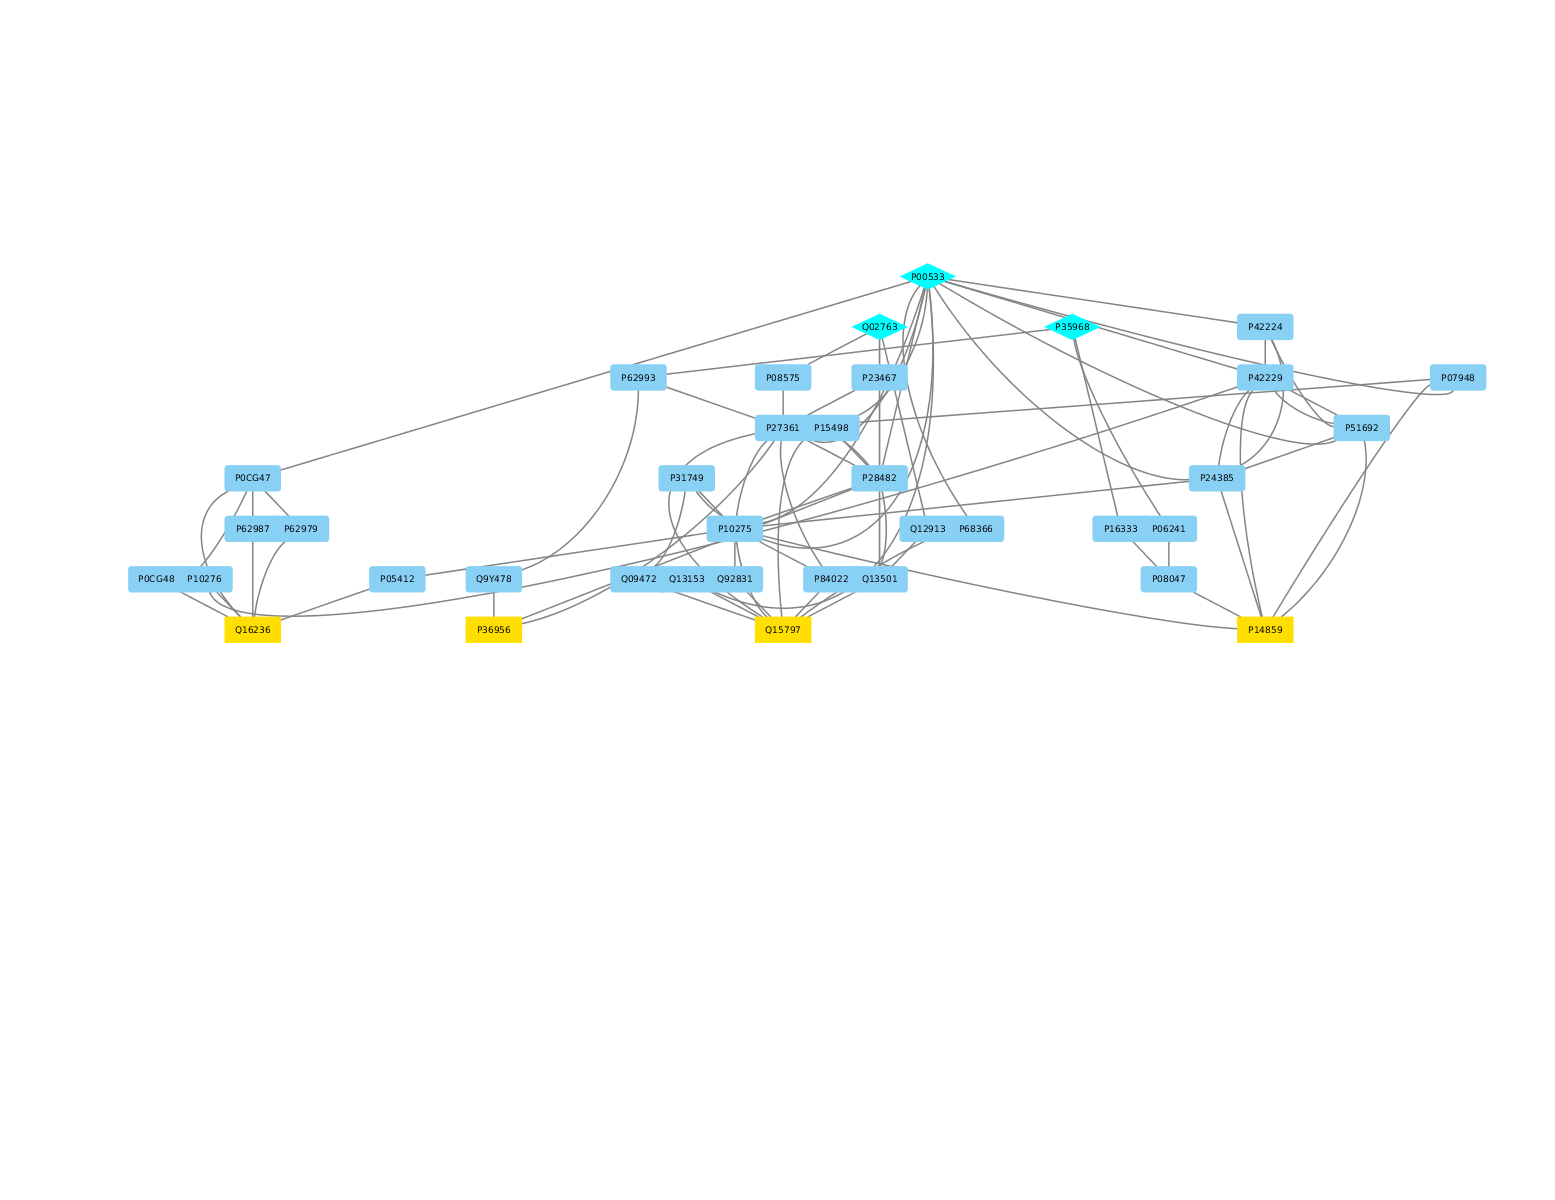

In [46]:
# png
subnetwork_image_png = subnetwork.get_png()
subnetwork_image_file = 'lovastatin-analysis-results/pathlinker-50-paths.png'
print("Writing PNG to %s" % (subnetwork_image_file))
with open(subnetwork_image_file, 'wb') as f:
    f.write(subnetwork_image_png)

from IPython.display import Image
Image(subnetwork_image_png)

# # pdf
# subnetwork_image_pdf = subnetwork.get_pdf()
# subnetwork_image_file = subnetwork_image_file.replace('.png', '.pdf')
# print("Writing PDF to %s" % (subnetwork_image_file))
# with open(subnetwork_image_file, 'wb') as f:
#     f.write(subnetwork_image_pdf)
# # display the pdf in frame
# from IPython.display import IFrame
# IFrame('use_case_images/subnetwork_image.pdf', width=600, height=300)

# # svg
# subnetwork_image_svg = subnetwork.get_svg()

# from IPython.display import SVG
# SVG(subnetwork_image_svg)

## Analyze the Subnetwork

Next, we need to recreate the functional enrichment analysis on the proteins in the subnetwork. 
TODO figure out how to run ClueGO